Week 05 Project

In [7]:
# packages

# import fin_package as fin
import pandas as pd
from scipy.stats import t, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

from scipy.stats import moment
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from scipy.stats import norm, t, lognorm
from scipy.optimize import minimize
import time
from tqdm import tqdm
import math
from datetime import datetime
from tqdm import tqdm
import os
import sys


- Problem 1:

Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions.
Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

In [9]:
def mle_normal_distribution_one_input(X):
    # Define the likelihood function for the normal distribution
    def log_likelihood(params, X):
        mean, var = params
        n = len(X)
        # Adjust X to be centered around the mean
        adjusted_X = X - mean
        # Get squared variance
        var2 = var**2
        # Calculate log likelihood
        log_likeli = -(n/2) * np.log(var2 * 2 * np.pi) - np.sum(adjusted_X**2) / (2 * var2)

        return -log_likeli

    # Calculate initial guess for mean and standard deviation
    mean_guess = np.mean(X, axis=0)
    std_dev_guess = np.std(X, axis=0)
    
    # Initial guess for optimization as a 1D array
    initial_params = np.array([mean_guess, std_dev_guess])

    # Perform optimization through minimization of log likelihood
    result = minimize(log_likelihood, initial_params, args=(X,))

    # Extract optimized parameters
    optimized_mean, optimized_std_dev = result.x

    # Print optimized mean and standard deviation
    print("Optimized Mean:", optimized_mean)
    print("Optimized Standard Deviation:", optimized_std_dev)

    return optimized_mean, optimized_std_dev



def mle_t_distribution_one_input(y):
    # Define the likelihood function for the t-distribution
    def neg_log_likelihood(params, y):
        mean, var, df = params
        adjusted_y = y - mean
        log_likeli = -np.sum(t.logpdf(adjusted_y, df, loc=mean, scale=var))
        return log_likeli

    # Calculate initial guess for mean, standard deviation, and degrees of freedom
    mean_guess = np.mean(y)
    std_dev_guess = np.std(y)
    _, _, df_guess = t.fit(y)

    # Initial guess for optimization
    initial_params = [mean_guess, std_dev_guess, df_guess]

    # Perform optimization through minimization of negative log likelihood
    result = minimize(neg_log_likelihood, initial_params, args=(y,), method='Nelder-Mead')

    # Extract optimized parameters
    optimized_mean, optimized_std_dev, optimized_df = result.x

    return optimized_mean, optimized_std_dev, optimized_df

# Calculate VaR Normal Distribution:
def calc_var_normal(mean, std_dev, alpha=0.05):
    VaR = norm.ppf(alpha, loc=mean, scale=std_dev)

    return -VaR

# Calculte VaR T Distribution:
def calc_var_t_dist(mean, std_dev, df, alpha=0.05):
    VaR = t.ppf(q=alpha, df=df, loc=mean, scale=std_dev)

    return -VaR


# Calculate ES for Normal
def calc_expected_shortfall_normal(mean, std_dev, alpha=0.05):
    
    # Calculate ES using the formula
    es = -1*mean + (std_dev * norm.pdf(norm.ppf(alpha, mean, std_dev)) / alpha)

    return es

# Calculate ES for Generalized T Distribution
def calc_expected_shortfall_t(mean, std_dev, df, alpha=0.05):
    # VaR for t dist
    var = -1*calc_var_t_dist(mean, std_dev, df, alpha=alpha)

    # PDF fucntion for t dist
    def t_pdf(x):
        return t.pdf(x, df, loc=mean, scale=std_dev)

    # Integrand for es
    def integrand(x):
        return x*t_pdf(x)

    # Calc ES using integration
    es, _ = quad(integrand, float("-inf"), var)

    return es/alpha

Optimized Mean: -0.0008798294897083734
Optimized Standard Deviation: 0.04886453171494587
Normal Optimized Mean: -0.0008798294897083734
Normal Optimized Std: 0.04886453171494587
T Optimized Mean: -4.687518394379098e-05
T Optimized Std: 0.03643900710824868
T Optimized DF: 4.25112498410904
VaR Normal Dist: -0.08125483171032236
VaR T Dist: -0.07642933758137249
Expected Shortfall for Norm Dist: -0.38947743574908994
Expected Shortfall for T Dist: -0.11317111110970036


/var/folders/72/nxfcp8kj65bbt3qtv2krff1w0000gn/T/ipykernel_98989/2221364419.py:23: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(log_likelihood, initial_params, args=(X,))


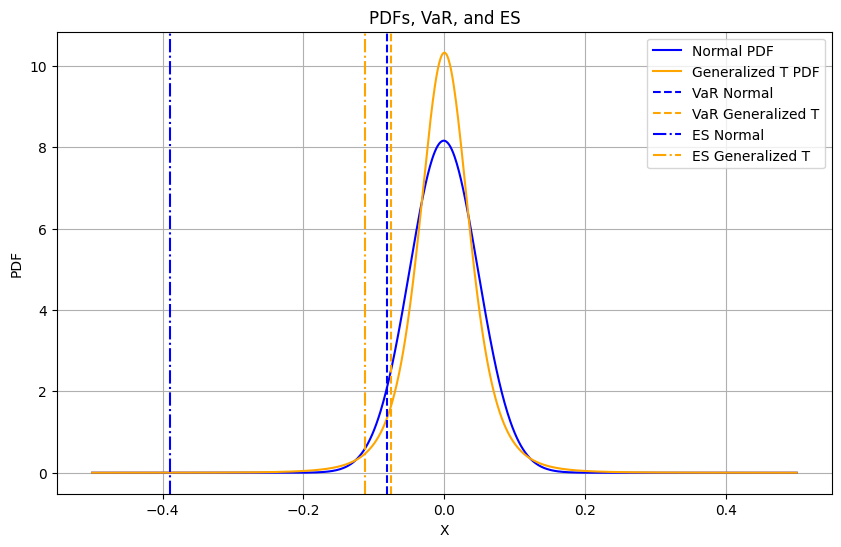

In [10]:
data = pd.read_csv(
    "/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/FinTech545/Week05/Project/problem1.csv"
)

# Fit Normal Distribution to data
norm_mean, norm_std = mle_normal_distribution_one_input(data)

print(f"Normal Optimized Mean: {norm_mean}")
print(f"Normal Optimized Std: {norm_std}")
# Fit Generalized T Distribution to this data
t_mean, t_std, t_df = mle_t_distribution_one_input(data.values)
# t_mean, t_std, t_df = t.fit(data.values)

print(f"T Optimized Mean: {t_mean}")
print(f"T Optimized Std: {t_std}")
print(f"T Optimized DF: {t_df}")

# Calculate VaR for Normal
var_normal = -1 * calc_var_normal(norm_mean, norm_std)
print(f"VaR Normal Dist: {var_normal}")

# Calculate VaR for Generalized T
var_t = -1 * calc_var_t_dist(t_mean, t_std, t_df)
print(f"VaR T Dist: {var_t}")

# Calculate ES for Normal

es_norm = -1 * calc_expected_shortfall_normal(norm_mean, norm_std, alpha=0.05)
print(f"Expected Shortfall for Norm Dist: {es_norm}")

# Calculate ES for Generalized T

es_t = calc_expected_shortfall_t(t_mean, t_std, t_df)
print(f"Expected Shortfall for T Dist: {es_t}")
# Overlay graphs of PDFs, VaR, ES

# Generate a range of x values for plotting
x = np.linspace(-0.5, 0.5, 1000)

# PDF for Normal Distribution
pdf_normal = norm.pdf(x, loc=norm_mean, scale=norm_std)

# PDF for Generalized T Distribution
pdf_t = t.pdf(x, t_df, loc=t_mean, scale=t_std)

# Plot the PDFs
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_normal, label="Normal PDF", color="blue")
plt.plot(x, pdf_t, label="Generalized T PDF", color="orange")

# VaR lines
plt.axvline(x=var_normal, color="blue", linestyle="--", label="VaR Normal")
plt.axvline(x=var_t, color="orange", linestyle="--", label="VaR Generalized T")

# ES lines
plt.axvline(x=es_norm, color="blue", linestyle="-.", label="ES Normal")
plt.axvline(x=es_t, color="orange", linestyle="-.", label="ES Generalized T")

plt.xlabel("X")
plt.ylabel("PDF")
plt.legend()
plt.title("PDFs, VaR, and ES")
plt.grid(True)
plt.show()

- Problem 2:

In your main repository, create a Library for risk management. Create modules, classes, packages, etc as you see fit. Include all the functionality we have discussed so far in class. Make sure it includes
1. Covariance estimation techniques.
2. Non PSD fixes for correlation matrices
3. Simulation Methods
4. VaR calculation methods (all discussed)
5. ES calculation
Create a test suite and show that each function performs as expected.

- Problem 3:

Use your repository from #2.
Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0. This file contains the stock holdings of 3 portfolios. You own each of these portfolios.
Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

In [19]:
def return_calculate(prices_df, method="DISCRETE", date_column="Date"):
    vars = prices_df.columns
    n_vars = len(vars)
    vars = [var for var in vars if var != date_column]
    
    if n_vars == len(vars):
        raise ValueError(f"date_column: {date_column} not in DataFrame: {vars}")
    
    n_vars = n_vars - 1
    
    p = prices_df[vars].values
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.empty((n-1, m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i, j] = p[i+1, j] / p[i, j]
    
    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")
    
    dates = prices_df[date_column].iloc[1:]
    
    # Create a new DataFrame with all columns
    data = {date_column: dates}
    for i in range(n_vars):
        data[vars[i]] = p2[:, i]
    
    out = pd.DataFrame(data)
    
    return out

def portfolio_es(portfolio, stock_dict, dist = "T"):
    if dist == "T":
        portfolio_es_individual = []
        for stock in portfolio['Stock']:
            mean = stock_dict[stock]['mean']
            std_dev = stock_dict[stock]['std_dev']
            df = stock_dict[stock]['df']
            stock_es = calc_expected_shortfall_t(mean, std_dev, df, alpha=0.05)
            stock_es *= portfolio.loc[portfolio['Stock'] == stock, 'Holding']
            portfolio_es_individual.append(stock_es)
        return np.mean(portfolio_es_individual)


In [22]:
def calculate_ewma_covariance_matrix(df, lambd):
    # Get the number of time steps n and vars m
    n, m = df.shape  
    
    # Initialize the exponentially weighted covariance matrix as a square matrix with dimensions (m, m)
    ewma_cov_matrix = np.zeros((m, m))  
    
    # Calculate the weights and normalized weights for each time step
    # w_{t_i} = (1-lambda)*lambda^{i-1}
    weights = [(1 - lambd) * lambd**(i) for i in range(n)]  
    weights = weights[::-1]
    #### Flip the weights

    # Calculate the sum of weights to normalize them
    total_weight = sum(weights)  # sum w_{t-j}
    
    # Normalize the weights by dividing each weight by the total weight
    # w_{t_i}^hat = w_{t_i} / sum w_{t-j}
    normalized_weights = [w / total_weight for w in weights]  
    
    # Calculate the means for each variable across all time steps
    means = df.mean(axis=0)  
    
    # Calculate the exponentially weighted covariance matrix
    for t in range(n):
        # Calculate the deviation of each variable at time t from its mean
        deviation = df.iloc[t, :] - means  
        
        # weighted deviation from means for x and y
        ewma_cov_matrix += normalized_weights[t] * deviation.values.reshape(-1, 1) @ deviation.values.reshape(1, -1)
    ewma_cov_matrix = pd.DataFrame(ewma_cov_matrix)
    return ewma_cov_matrix

In [20]:
def calculate_portfolio_var(portfolio, price_df, returns_df, lambd, alpha = 0.05):
    # calculate total portfolio value
    portfolio_value = 0.0
    # create array to store each stock's value
    delta = []
    for _, row in portfolio.iterrows():
        stock_value = row['Holding']*price_df[row['Stock']].iloc[-1]
        portfolio_value += stock_value
        delta.append(stock_value)

    print(f"Portfolio Value: {portfolio_value}")
    delta = np.array(delta)
    normalized_delta = delta / portfolio_value
    
    exp_weighted_cov = calculate_ewma_covariance_matrix(returns_df, lambd)
    exp_weighted_std = np.sqrt(np.diagonal(exp_weighted_cov))
    
    # Create a dictionary to store column titles and corresponding exp_weighted_std values
    result_dict = {column: std for column, std in zip(returns_df.columns, exp_weighted_std)}
    
    exp_weighted_std_portfolio = np.array([result_dict[stock] for stock in portfolio['Stock']])

    p_sig = np.sqrt(np.dot(np.dot(normalized_delta, exp_weighted_std_portfolio), normalized_delta))
    
    VaR = -delta * norm.ppf(1-alpha)*p_sig
    total_VaR = sum(VaR)

    print(f"Porftolio Value at Risk: ${total_VaR}\n")
    return total_VaR

In [17]:


# Using Portfolio.csv & DailyPrices.csv, assume expected return on all stocks is 0
# dailyprices = pd.read_csv(os.path.abspath("DailyPrices.csv"))
# portfolio = pd.read_csv(os.path.abspath("portfolio.csv"))

dailyprices = pd.read_csv(
    "/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/FinTech545/Week05/Project/DailyPrices.csv"
)   
portfolio = pd.read_csv("/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/FinTech545/Week05/Project/portfolio.csv")

returns = return_calculate(dailyprices).drop("Date", axis=1)
# Portfolios of A, B, C
portfolio_a = portfolio[portfolio['Portfolio'] == "A"]
portfolio_b = portfolio[portfolio['Portfolio'] == "B"]
portfolio_c = portfolio[portfolio['Portfolio'] == "C"]

In [18]:
# Fit a Generalized T model to each stock
t_dist_dict = {}
stocks = portfolio['Stock']
for stock in tqdm(stocks, desc="Fitting T-Distribution to Stocks"):
    s_df, s_mean, s_std = t.fit(dailyprices[stock])
    stock_dict = {
        'mean': s_mean,
        'std_dev': s_std,
        'df': s_df
    }
    t_dist_dict[stock] = stock_dict

Fitting T-Distribution to Stocks: 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


In [23]:
lambd = 0.97
# Calculate VaR of A
print("Value at Risk: Portfolio A")
A_var = -calculate_portfolio_var(portfolio_a, dailyprices, returns, lambd)

# Calculate VaR of B
print("Value at Risk: Portfolio B")
B_var = -calculate_portfolio_var(portfolio_b, dailyprices, returns, lambd)

# Calculate VaR of C
print("Value at Risk: Portfolio C")
C_var = -calculate_portfolio_var(portfolio_c, dailyprices, returns, lambd)

# Calculate VaR of Total Portfolio
print("Value at Risk: Portfolio Whole")
Port_var = -calculate_portfolio_var(portfolio, dailyprices, returns, lambd)

# Calculate ES of A
es_vals_a = portfolio_es(portfolio_a, t_dist_dict, dist = "T")
print(f"Expected Shortfall: Portfolio A -- {es_vals_a}")

# Calculate ES of B
es_vals_b = portfolio_es(portfolio_b, t_dist_dict, dist = "T")
print(f"Expected Shortfall: Portfolio B -- {es_vals_b}")
# Calculate ES of C
es_vals_c = portfolio_es(portfolio_c, t_dist_dict, dist = "T")
print(f"Expected Shortfall: Portfolio C -- {es_vals_c}")
# Calculate ES of Total Portfolio
es_vals_all = portfolio_es(portfolio, t_dist_dict, dist = "T")
print(f"Expected Shortfall: Portfolio All -- {es_vals_all}")

Value at Risk: Portfolio A
Portfolio Value: 1089316.15994
Porftolio Value at Risk: $-48640.92546035711

Value at Risk: Portfolio B
Portfolio Value: 574542.4051499999
Porftolio Value at Risk: $-23741.26217599257

Value at Risk: Portfolio C
Portfolio Value: 1387409.5075200002
Porftolio Value at Risk: $-82029.31314315766

Value at Risk: Portfolio Whole
Portfolio Value: 3051268.07261
Porftolio Value at Risk: $-94545.15142292554



/Users/ahmedibrahim/opt/miniconda3/envs/ab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
/Users/ahmedibrahim/opt/miniconda3/envs/ab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in multiply
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


Expected Shortfall: Portfolio A -- 21169.70531499024
Expected Shortfall: Portfolio B -- 13503.182267559749
Expected Shortfall: Portfolio C -- 28448.632808833663
Expected Shortfall: Portfolio All -- 21114.588057244942


In [14]:
# def portfolio_es(portfolio, stock_dict, dist = "T"):
#     if dist == "T":
#         portfolio_es_individual = []
#         for stock in portfolio['Stock']:
#             mean = stock_dict[stock]['mean']
#             std_dev = stock_dict[stock]['std_dev']
#             df = stock_dict[stock]['df']
#             stock_es = fin.calculate_es_t_distribution(mean, std_dev, df, alpha=0.05)
#             portfolio_es_individual.append(stock_es)
#         return portfolio_es_individual